Import Libraries

In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.classification import MultilabelF1Score, MultilabelRecall, MultilabelPrecision

import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import os
from nltk import wordpunct_tokenize
import re
from torchvision import transforms
from tqdm import tqdm

Download data

In [3]:
!gdown 1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD
!unzip -qq ml1m.zip -d ml1m

Downloading...
From: https://drive.google.com/uc?id=1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD
To: /content/ml1m.zip
100% 105M/105M [00:00<00:00, 131MB/s]


Read data into train and test dataframes

In [4]:
users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

Movie genres visualization

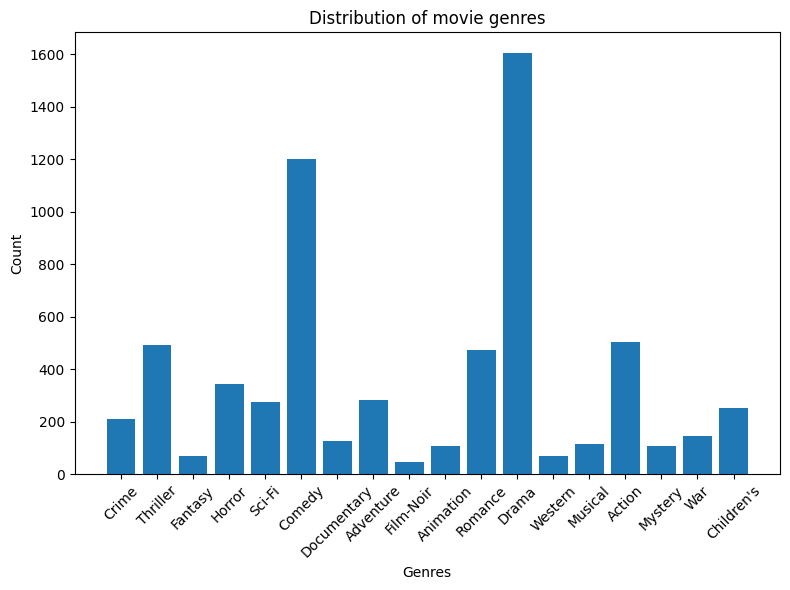

In [5]:
df = pd.concat([movies_train['genre'], movies_test['genre']], ignore_index=True)

categories_count = {}

with open('/content/ml1m/content/dataset/genres.txt', 'r') as f:
  genres = f.readlines()
  for genre in genres:
    categories_count[genre.split('\n')[0]] = 0


for genres in df:
  for genre in genres:
    categories_count[genre] += 1

categories = list(categories_count.keys())
values = list(categories_count.values())

# Plotting a bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, values)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Distribution of movie genres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Add image paths to the train and test dataframes

In [6]:
folder_img_path = 'ml1m/content/dataset/ml1m-images'

movies_train.reset_index(inplace=True)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(folder_img_path, f'{row.movieid}.jpg'), axis = 1)

movies_test.reset_index(inplace=True)
movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(folder_img_path, f'{row.movieid}.jpg'), axis = 1)

movies_train, movies_dev = movies_train[:int(0.8*len(movies_train))].reset_index(drop=True), movies_train[int(0.8*len(movies_train)):].reset_index(drop=True)

Title normalizer for title normalization :D

In [7]:
def title_normalizer(text):
  parts = text.split(',')
  if len(parts) > 1:
    return (parts[1][:-6] + parts[0]).strip()
  else:
    return text[:-6].strip()

Apply them to the 3-df

In [8]:
movies_train.loc[:, 'title'] = movies_train['title'].apply(lambda x: title_normalizer(x))
movies_dev.loc[:, 'title'] = movies_dev['title'].apply(lambda x: title_normalizer(x))
movies_test.loc[:, 'title'] = movies_test['title'].apply(lambda x: title_normalizer(x))


Data dict

In [9]:
data = {
    'train': movies_train,
    'dev': movies_dev,
    'test': movies_test
}

Create train, valid and test folders. And then move data to it.

In [10]:
# import shutil

# train_path = '/content/ml1m/content/dataset/train'
# valid_path = '/content/ml1m/content/dataset/dev'
# test_path = '/content/ml1m/content/dataset/test'

# if not os.path.isdir(train_path):
#   os.makedirs(train_path)
# if not os.path.isdir(valid_path):
#   os.makedirs(valid_path)
# if not os.path.isdir(test_path):
#   os.makedirs(test_path)


# for i in range(len(movies_train)):
#   src_file = movies_train.iloc[i,3]
#   if os.path.exists(src_file):
#     shutil.copy(src_file, train_path)


# for i in range(len(movies_dev)):
#   src_file = movies_dev.iloc[i,3]
#   if os.path.exists(src_file):
#     shutil.copy(src_file, valid_path)


# for i in range(len(movies_test)):
#   src_file = movies_test.iloc[i,3]
#   if os.path.exists(src_file):
#     shutil.copy(src_file, test_path)

In [11]:
class Vocab:
  def __init__(self, freq_threshold, max_size):
    self.freq_threshold = freq_threshold
    self.max_size = max_size
    self.itos = {0:'<pad>', 1:'<sos>', 2:'<eos>', 3:'<unk>'}
    self.stoi = {j:i for i, j in self.itos.items()}


  def __len__(self):
    return len(self.itos)


  @staticmethod
  def tokenizer(text):
    return wordpunct_tokenize(text.lower())


  def build_vocab(self, sentence_list):
    freqs = {}
    idx = 4


    for sentence in sentence_list:
      for word in self.tokenizer(sentence):
        if word not in freqs.keys():
          freqs[word] = 1
        else:
          freqs[word] += 1


    freqs = {k:v for k,v in freqs.items() if v > self.freq_threshold}

    if len(freqs) > self.max_size-idx:
      freqs = dict(sorted(freqs.items(), key = lambda x : -x[1])[:self.max_size-idx])

    for word in freqs.keys():
      self.stoi[word] = idx
      self.itos[idx] = word
      idx += 1


  def numericalize(self, text):
    tokenized_text = self.tokenizer(text)
    numericalized_text = []
    for token in self.tokenizer(text):
      if token in self.stoi.keys():
        numericalized_text.append(self.stoi[token])
      else:
        numericalized_text.append(self.stoi['<unk>'])

    return numericalized_text


In [12]:
class Genre():
  def __init__(self, genres):
    self.genres = genres


  def genres2idx(self, genres):
    genre_vector = np.zeros(len(categories_count))

    for idx, genre in enumerate(categories_count.keys()):
      if genre in self.genres:
        genre_vector[idx] = 1

    return torch.from_numpy(genre_vector)

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [14]:
class Movie(Dataset):
  def __init__(self, data, dataset_type, transform=None, freq_threshold=5, max_vocab_size=1000):
    self.data = data[dataset_type]
    self.transform = transform

    ## NLP
    self.title = self.data.title
    self.vocab = Vocab(freq_threshold, max_vocab_size)
    self.vocab.build_vocab(self.title.tolist())
    self.max_title_size = 0

    for x in self.title:
      self.max_title_size = max(self.max_title_size, len(x))

    ## CV
    self.images = self.data.img_path

    self.genres = self.data.genre

  def __len__(self):
    return len(self.data)


  def __getitem__(self, index):
    title = self.title[index]
    image = self.images[index]
    genres = Genre(self.genres[index])
    genres_tensor = genres.genres2idx(genres)

    ## NLP
    title_tensor = [self.vocab.stoi['<sos>']]
    title_tensor += self.vocab.numericalize(title)
    title_tensor.append(self.vocab.stoi['<eos>'])
    while (len(title_tensor) < self.max_title_size):
      title_tensor.append(self.vocab.stoi['<pad>'])
    title_tensor = torch.tensor(title_tensor)

    ## CV
    if os.path.exists(image):
      img = cv2.imread(image)
    else:
      img = np.random.rand(256,256,3)
    img = cv2.resize(img, (256,256))
    image_tensor = torch.from_numpy(img.transpose(2,0,1)).float()

    return title_tensor, image_tensor, genres_tensor

In [15]:
trainset = Movie(data, 'train')
train_loader = DataLoader(trainset, shuffle=True, batch_size=512)

devset = Movie(data, 'dev')
dev_loader = DataLoader(devset, shuffle=True, batch_size=256)

testset = Movie(data, 'test')
test_loader = DataLoader(testset, shuffle=True, batch_size=256)

In [16]:
class ModelVip(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes):
    super(ModelVip, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(4, 4)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.fc_cnn = nn.Linear(32 * 16 * 16, 128)

    self.embed = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
    self.fc_lstm = nn.Linear(hidden_dim, 128)

    self.fc1 = nn.Linear(2 * 128, 64)
    self.fc2 = nn.Linear(64, num_classes)

    self.dropout = nn.Dropout(0.2)

  def forward(self, title_tensor, image_tensor):
    cnn = self.pool(self.dropout(F.relu(self.conv1(image_tensor))))
    cnn = self.pool(self.dropout(F.relu(self.conv2(cnn))))
    cnn = torch.flatten(cnn, 1)
    cnn = F.relu(self.fc_cnn(cnn))

    lstm = self.embed(title_tensor)
    lstm, (hidden, cell) = self.lstm(lstm)
    lstm_out = self.fc_lstm(hidden[-1])

    out = F.relu(self.fc1(torch.concat([cnn, lstm_out], dim=1)))
    out = self.fc2(out)

    return out

In [17]:
PATH = '/content/ml1m/content/dataset/model.pt'

n_classes = len(categories_count)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab = Vocab(5, 1000)
vocab.build_vocab(data['train'].title.tolist())
print('Vocab size: ', str(len(vocab)))

model = ModelVip(vocab_size=len(vocab), embedding_dim = 20, hidden_dim = 64, num_layers = 2, num_classes=n_classes)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

f1 = MultilabelF1Score(num_labels=len(categories_count))
f1 = f1.to(device)
recall = MultilabelRecall(num_labels=len(categories_count))
recall = recall.to(device)
precision = MultilabelPrecision(num_labels=len(categories_count))
precision = precision.to(device)

Vocab size:  185
ModelVip(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_cnn): Linear(in_features=8192, out_features=128, bias=True)
  (embed): Embedding(185, 20)
  (lstm): LSTM(20, 64, num_layers=2, batch_first=True)
  (fc_lstm): Linear(in_features=64, out_features=128, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=18, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [18]:
epochs = 20
clip = 5

best_f1 = 0
best_tuple = ()
best_epoch = 0

for epoch in range(1, epochs+1):
    total_acc_train = 0
    total_loss_train = 0

    model.train()

    for title, image, genres in tqdm(train_loader):
      title = title.to(device)
      image = image.to(device)
      genres = genres.to(device)

      optimizer.zero_grad()
      out = model(title, image)
      loss = criterion(out, genres)
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

      optimizer.step()

      with torch.no_grad():
        acc = ((out > 0.5).float() == genres).float().mean().item()
        total_acc_train += acc
        total_loss_train += loss.item()

    train_acc = total_acc_train / len(train_loader)
    train_loss = total_loss_train / len(train_loader)

    model.eval()

    total_acc_val = 0
    total_loss_val = 0
    f1_all = 0
    recall_all = 0
    precision_all = 0

    with torch.no_grad():
      for title, image, genres in dev_loader:
        title = title.to(device)
        image = image.to(device)
        genres = genres.to(device)

        out = model(title, image)
        val_loss = criterion(out, genres)

        f1_val = f1(out, genres)
        f1_all += f1_val
        recall_val = recall(out, genres)
        recall_all += recall_val
        precision_val = precision(out, genres)
        precision_all += precision_val

        acc = ((out > 0.5).float() == genres).float().mean().item()
        total_acc_val += acc
        total_loss_val += val_loss.item()


    val_acc = total_acc_val / len(dev_loader)
    val_loss = total_loss_val / len(dev_loader)

    f1_all = f1_all / len(dev_loader)
    recall_all = recall_all / len(dev_loader)
    precision_all = precision_all / len(dev_loader)

    if f1_all > best_f1:
      best_f1 = f1_all
      best_epoch = epoch
      best_tuple = train_loss, train_acc, val_loss, val_acc, precision_all, recall_all
      torch.save(model.state_dict(), PATH)

    if epoch == 1:
      print(f'Epoch  |     Train Loss     |     Train Accuracy     |     Valid Loss     |     Valid Accuracy     |     Precision     |     Recall     |     F1-Score     |')

    print(f'{epoch:^7d}|{train_loss:^20.4f}|{train_acc:^24.4f}|{val_loss:^20.4f}|{val_acc:^24.4f}|{precision_all:^19.4f}|{recall_all:^16.4f}|{f1_all:^18.4f}|')

    if epoch % 5 == 0:
      print('==========================================================================BEST=============================================================================')
      print(f'{best_epoch:^7d}|{best_tuple[0]:^20.4f}|{best_tuple[1]:^24.4f}|{best_tuple[2]:^20.4f}|{best_tuple[3]:^24.4f}|{best_tuple[4]:^19.4f}|{best_tuple[5]:^16.4f}|{best_f1:^18.4f}|')
      print('===========================================================================================================================================================')

    torch.cuda.empty_cache()

100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Epoch  |     Train Loss     |     Train Accuracy     |     Valid Loss     |     Valid Accuracy     |     Precision     |     Recall     |     F1-Score     |
   1   |      49.6409       |         0.5830         |      31.2545       |         0.5726         |      0.0714       |     0.5412     |      0.1136      |


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


   2   |      27.3190       |         0.5478         |       6.1982       |         0.4388         |      0.0904       |     0.7278     |      0.1461      |


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


   3   |       5.6093       |         0.4650         |       4.3915       |         0.7056         |      0.0916       |     0.8366     |      0.1521      |


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


   4   |       4.3622       |         0.6555         |       4.2598       |         0.7286         |      0.0909       |     0.7548     |      0.1502      |


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


   5   |       4.2238       |         0.6969         |       4.2422       |         0.7059         |      0.0971       |     0.5998     |      0.1557      |
==========================================================================BEST=============================================================================
   5   |       4.2238       |         0.6969         |       4.2422       |         0.7059         |      0.0971       |     0.5998     |      0.1557      |


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


   6   |       4.0861       |         0.6712         |       4.0972       |         0.7698         |      0.0920       |     0.5890     |      0.1510      |


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


   7   |       3.8935       |         0.6883         |       4.0049       |         0.6959         |      0.0889       |     0.5917     |      0.1459      |


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


   8   |       3.7295       |         0.6502         |       4.0540       |         0.7091         |      0.1018       |     0.6598     |      0.1583      |


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


   9   |       3.5514       |         0.6613         |       4.1160       |         0.6593         |      0.0993       |     0.6673     |      0.1619      |


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


  10   |       3.3620       |         0.6258         |       4.0722       |         0.6543         |      0.1032       |     0.6878     |      0.1690      |
==========================================================================BEST=============================================================================
  10   |       3.3620       |         0.6258         |       4.0722       |         0.6543         |      0.1032       |     0.6878     |      0.1690      |


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


  11   |       3.1610       |         0.6053         |       4.0709       |         0.5710         |      0.0982       |     0.7396     |      0.1628      |


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


  12   |       2.9676       |         0.5446         |       4.1733       |         0.5624         |      0.0998       |     0.7197     |      0.1648      |


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


  13   |       2.7815       |         0.5426         |       4.2474       |         0.5306         |      0.1016       |     0.7930     |      0.1696      |


100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


  14   |       2.6213       |         0.5187         |       4.3126       |         0.5310         |      0.1026       |     0.7968     |      0.1707      |


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


  15   |       2.4856       |         0.5258         |       4.4954       |         0.5464         |      0.1017       |     0.7650     |      0.1683      |
==========================================================================BEST=============================================================================
  14   |       2.6213       |         0.5187         |       4.3126       |         0.5310         |      0.1026       |     0.7968     |      0.1707      |


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


  16   |       2.3853       |         0.5432         |       4.4793       |         0.5255         |      0.1043       |     0.7816     |      0.1737      |


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


  17   |       2.2932       |         0.5339         |       4.6068       |         0.5255         |      0.1038       |     0.7746     |      0.1725      |


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


  18   |       2.1902       |         0.5362         |       4.7032       |         0.5366         |      0.1036       |     0.7811     |      0.1720      |


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


  19   |       2.0933       |         0.5416         |       4.7018       |         0.5224         |      0.1030       |     0.7739     |      0.1716      |


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


  20   |       2.0410       |         0.5269         |       4.7167       |         0.5151         |      0.1026       |     0.7555     |      0.1701      |
==========================================================================BEST=============================================================================
  16   |       2.3853       |         0.5432         |       4.4793       |         0.5255         |      0.1043       |     0.7816     |      0.1737      |


In [19]:
model.load_state_dict(torch.load(PATH))
model.eval()

total_acc_test = 0
total_loss_test = 0
outputs = []

with torch.no_grad():
  for title, image, genres in test_loader:
    title = title.to(device)
    image = image.to(device)
    genres = genres.to(device)

    out = model(title, image)
    loss = criterion(out, genres)

    f1_val = f1(out, genres)
    f1_all += f1_val

    recall_val = recall(out, genres)
    recall_all += recall_val
    precision_val = precision(out, genres)
    precision_all += precision_val

    acc = ((out > 0.5).float() == genres).float().mean().item()
    total_acc_test += acc
    total_loss_test += loss.item()

test_acc = total_acc_test / len(test_loader)
test_loss = total_loss_test / len(test_loader)

f1_all = f1_all / len(test_loader)
recall_all = recall_all / len(test_loader)
precision_all = precision_all / len(test_loader)

print(f'Test Accuracy: {test_acc:^10.4f}|Test Loss: {test_loss:^10.4f}|Precision: {precision_all:^10.4f}|Recall: {recall_all:^10.4f}|F1-Score: {f1_all:.4f}')

Test Accuracy:   0.5348  |Test Loss:   4.2152  |Precision:   0.1218  |Recall:   0.8484  |F1-Score: 0.1978
